In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad, nquad, simps
from scipy.special import ellipe, ellipk
from scipy.interpolate import lagrange, InterpolatedUnivariateSpline
from scipy.signal import savgol_filter

## Notes

__From rotmod.c:__ <br>
For the  sampling radii you should use an increment of about 0.2 times the disk scale length, and the maximum sampling radius should at least be larger than the radius of the last measured point on your observed rotation curve. <br>
If the user wants to enter a measured density profile, and the central density is not given (density at R=0), the program will use linear extrapolation to obtain the central density.

## User input

In [2]:
user = True  # use imported data

# Gas:
# Conversion to linear scale was made in the notebook: grav_project/NGC_5005/Gas_from_mass_surface_density.ipynb
raddens = "../data/gasmsd_kpc_linear.txt"      # Gas density with 2 columns, units: KPC, MSUN/PC^2
units = 'KPC,MSUN/PC**2'
radii = np.arange(0.1,11.18,0.1)                # Sampling radii

# Disk:
# See for more: grav_project/NGC_5005/Disk_from_surface_brightness_profile.ipynb
#raddens = "../data/NGC5005-disk_arcsec.txt"    # Disk surface brightness with 4 colums, units: ARCSEC, MAG/ARCSEC^2
#units = 'ARCSEC,MAG/ARCSEC**2'
#radii = np.arange(0.001,35,0.01)

zlaw = 2                            # Case 2: sech-squared density law
mode = zlaw                         # Density distribution mode

# Parameters
G = 0.00000431158                   # Gravitational constant (KPC/MSUN*(KM/S)^2)  
CONSTANT = 2.0 * np.pi * G / 3.0
EPS = 0.000001
z0 = 0.93
distance = 16.5                    # Distance in MPC

# we only need dens0 and h if user is FALSE (i.e. when density is calculated), otherwise we don't need it
h = 2                              # GUESS: radial scale-length (KPC)
#dens0 = 10**2.4                    # GUESS: central surface density (MSUN/PC^2): from Fig 8. Paper 13
dens0 = 4e2                        # GUESS: central surface density (MSUN/PC^2)

## Density distribution

In [3]:
# There are three distribution laws possible; 
# the Van der Kruit and Searle law (SECH-SQUARED): D(Z)=sech(Z/Z0)**2/Z0,
# an exponential density law (EXPONENTIAL): D(Z)=exp(-Z/Z0)/Z0 
# a simple sech law (SIMPLE-SECH): D(Z)=2*sech(Z/Z0)/Z0/PI. 

# case 1 is a flat disk, z0 = 0
#####################################

# Sech-squared law:
def denzed_case2(z,z0): 
    r = np.cosh(z / z0)
    #r = r * r * z0    # In the GIPSY rotmod.c, this is multiplied by z0 but in Caserano Eq 2 there isn't any z0
    r = r * r
    r = 1.0 / r
    return r           # calling this r is kind of misleading but Rotmod is calling it r
                       # returns: density as a function of z (I think)

# Exponential:
def denzed_case3(z,z0):
    r = np.exp(-z / z0) /z0
    return r

# Simple-sech
def denzed_case4(z,z0):
    r = 2 / z0 / np.pi / np.cosh(z/z0)
    return r

def denzed(z,z0,mode):
    #The above results in the user being asked for every point entered; this was likely used as a backend.
    if mode == 2:
        return denzed_case2(z,z0)
    if mode == 3:
        return denzed_case3(z,z0)
    if mode == 4:
        return denzed_case4(z,z0)
    else:
        return np.nan
        print("Error occured in denzed; no mode selected. Returned nan.")

## Density profile

In [4]:
def DensityProfile(user=user,raddens=raddens,units=units,mode=mode,dens0=dens0,h=h):
    
    ##################################
    # Case 1: Import density profile #
    ##################################
    
    if user == True:
        if units == 'KPC,MSUN/PC**2':
            mudata = np.loadtxt(raddens)
            if np.shape(np.loadtxt(raddens))[1] == 2:     # this just checks if the file has 2 or 4 columns
                xdinp, ydinp = mudata.T
            if np.shape(np.loadtxt(raddens))[1] == 4:
                xdinp, ydinp, xerror, yerror = mudata.T

        if units == 'ARCSEC,MAG/ARCSEC**2':
            mudata = np.loadtxt(raddens)
            if np.shape(np.loadtxt(raddens))[1] == 2:
                xdinp, ydinp = mudata.T
            if np.shape(np.loadtxt(raddens))[1] == 4:
                xdinp, ydinp, xerror, yerror = mudata.T

            # Conversion
            # ARCSEC to KPC
            xdinp = 4.8481E-3 * distance * xdinp

            # MAG/ARCSEC^2 to MSUN/PC^2
            ydinp = 10**(-0.4 * ydinp)
            ydinp = (4.8481E-3 * distance)**(-2) * ydinp
            
        if units == 'KPC,MAG/ARCSEC**2':
            mudata = np.loadtxt(raddens)
            if np.shape(np.loadtxt(raddens))[1] == 2:
                xdinp, ydinp = mudata.T
            if np.shape(np.loadtxt(raddens))[1] == 4:
                xdinp, ydinp, xerror, yerror = mudata.T

            # Conversion
            # MAG/ARCSEC^2 to MSUN/PC^2
            ydinp = 10**(-0.4 * ydinp)
            ydinp = (4.8481E-3 * distance)**(-2) * ydinp
            
        LEN1 = len(xdinp)                   # GUESS: defined as length of radius array
        LEN2 = len(ydinp)                   # GUESS: defined as lenght of density array
        ndinp = LEN2                        # number of surface densities. GUESS: length of density array again
        rcut = xdinp[ndinp-1]               # takes second to last radius value
        delta = rcut - xdinp[ndinp-2]       # difference between the second to last radius value and the third to last radius value
    
    
    #####################################
    # Case 2: Calculate density profile #
    #####################################
    
    if user == False:
    
        # User need to provide dens0 (in MSUN/PC^2) and h (in KPC)
        dens0 = dens0           # central density of exponential DISK
        # convert disk central surface brightness from MAG/ARCSEC^2 to MSUN/KPC^2
        #dens0 = 10**(-0.4 * dens0)       
        #dens0 = (4.8481E-3 * distance)**(-2) * dens0
        #dens0 = dens0 * 1.0e6        
        #print("dens0 = {:.4}".format(dens0))

        h = h                   # radial scale length
        z0 = 0.2*h              # scale height of DISK in kpc [0.0]. 
                                  # note: The integration in Z is the most time consuming part
                                  # of the calculation. For example it takes about 0.2 seconds
                                  # to calculate a point on the rotation curve for a disk with zero
                                  # thickness, and about 2 seconds for a disk with non-zero thickness.
        rcut = 4*h              # cutoff radius
        delta = 0.2*h           # softening parameter of DISK in kpc [0.0]. It may be wise
                                  # to have a non-zero softening in case of a truncated disk, 
                                  # because then the sharp features in the calculated rotation 
                                  # curve will be smoothed out. A softening parameter of about 
                                  # 0.2 scale lengths would be sufficient.

        # Now calculate the surface densities
        LEN1 = 1000
        LEN2 = 1000
        xdinp = np.zeros(LEN2-1)    # radii surface density
        ydinp = np.zeros(LEN2-1)    # surface densities
        rdinp = rcut + delta      # max radius, where galaxy ends
        ndinp = LEN2 - 1          # number of surface densities
        xstep = rdinp / (ndinp - 1)        # step in radius

        i = 0                              # counter 
        while i < ndinp:
            # Casertano's piecewise function (Eq.3)
            xdinp[i] = x = xstep * i
            if x >= rcut and delta > 0.0:
                y = dens0 * np.exp(-rcut/h)*(rcut+delta-x)/delta
            elif x >= rdinp:
                y = 0.0                    # end of disk
            else:
                y = dens0 * np.exp(-x/h)
            ydinp[i] = y
            i += 1
    return xdinp, ydinp, ndinp, rcut, delta, LEN1, LEN2

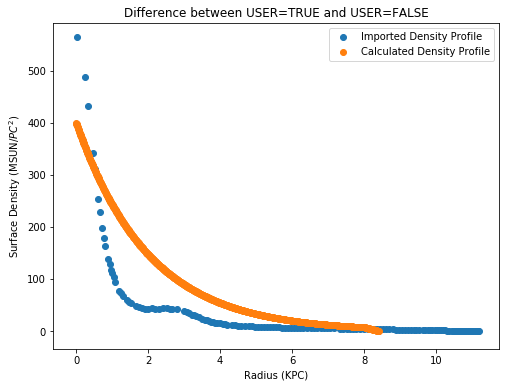

In [5]:
# Plot 
plt.figure(figsize=(8,6))
xdinp_imported = DensityProfile(user=True)[0]
ydinp_imported = DensityProfile(user=True)[1]
plt.scatter(xdinp_imported,ydinp_imported, label="Imported Density Profile")

xdinp_calculated = DensityProfile(user=False)[0]
ydinp_calculated = DensityProfile(user=False)[1]
plt.scatter(xdinp_calculated,ydinp_calculated, label="Calculated Density Profile")
plt.xlabel("Radius (KPC)")
plt.ylabel("Surface Density (MSUN/$PC^2$)")
plt.title("Difference between USER=TRUE and USER=FALSE")
plt.legend()
plt.show()

## Define some values

In [6]:
# Radius
xdinp = DensityProfile()[0]
# Density
ydinp = DensityProfile()[1]
print(ydinp)

# Cutoff radius
rcut = DensityProfile()[3]
# Cutoff length
delta = DensityProfile()[4]

[5.6363766e+02 4.8707967e+02 4.3151908e+02 3.4158595e+02 3.1031302e+02
 2.5392181e+02 2.2782428e+02 1.9683395e+02 1.7881337e+02 1.6311729e+02
 1.3918742e+02 1.2802654e+02 1.1778772e+02 1.1063690e+02 1.0303861e+02
 9.4362620e+01 7.7250270e+01 7.2861820e+01 6.7873460e+01 5.9634830e+01
 5.6014440e+01 5.3727920e+01 4.8607130e+01 4.6046860e+01 4.4167210e+01
 4.2716930e+01 4.2894340e+01 4.3251380e+01 4.2024250e+01 4.3082410e+01
 4.5112820e+01 4.3651580e+01 4.2043610e+01 4.2933870e+01 4.2579450e+01
 3.8850800e+01 3.6787480e+01 3.4562090e+01 3.1666500e+01 2.9984720e+01
 2.8054340e+01 2.6025560e+01 2.3741050e+01 2.2024190e+01 2.0516350e+01
 1.9511920e+01 1.8176070e+01 1.7072610e+01 1.6173350e+01 1.5317930e+01
 1.4507750e+01 1.3630130e+01 1.2909220e+01 1.2382260e+01 1.1392000e+01
 1.0972360e+01 1.0568180e+01 1.0094850e+01 9.6827800e+00 9.1706500e+00
 8.8715600e+00 8.4722700e+00 8.1959600e+00 7.9909800e+00 7.6983900e+00
 7.4131000e+00 7.2929000e+00 7.1729900e+00 7.0258700e+00 6.8501500e+00
 6.711

In [7]:
print(xdinp[0])
print(radii[0])

0.0172
0.1


## Interpolation

In [8]:
def interpd(x,y):
    #return lagrange(x,y)                # Lagrange interpolation didn't work well so I used Univariate Spline
    #return InterpolatedUnivariateSpline(x,y,k=4)   
    return InterpolatedUnivariateSpline(x,y,k=4)   

# Calculate the density values at the sampling radii
spline_rhor = interpd(xdinp,ydinp)        # define the polynomial that's calculated
print(spline_rhor)

519.1342891927233
563.63766


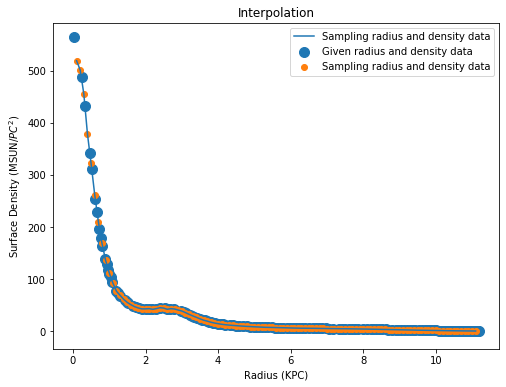

In [9]:
# Just for plotting: evaluate values at the sampling radii 
density = spline_rhor(radii)
print(density[0])
print(ydinp[0])

# Plot 
plt.figure(figsize=(8,6))
plt.scatter(xdinp,ydinp, label="Given radius and density data", s=100)
plt.scatter(radii,density, label="Sampling radius and density data")
plt.plot(radii,density, label="Sampling radius and density data")
plt.title("Interpolation")
plt.xlabel("Radius (KPC)")
plt.ylabel("Surface Density (MSUN/$PC^2$)")
plt.legend()
plt.show()

## Partial derivative / Smoothing

In [10]:
# Partial derivative of rho(u,z) with respect to u
# Taking the derivative of the splined polynomial (radius and density values, rho(r) or rho(u))
drho_du = spline_rhor.derivative()

# Evaluating at given radii
drho_du_values = drho_du(radii)

# Smoothing: Savitzky-Golay filter: https://riptutorial.com/scipy/example/15878/using-a-savitzky-golay-filter
drho_du_smooth = savgol_filter(drho_du_values, 11, 5)  # window size 11, polynomial order 6

# Spline the smoothed derivative
spline_drhor = interpd(radii,drho_du_smooth)

C:\Users\JB\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


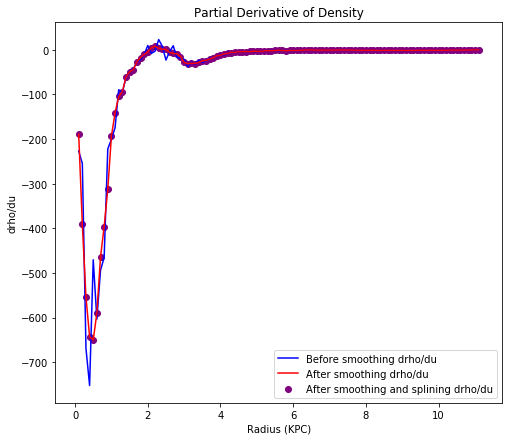

In [11]:
# Plot 
plt.figure(figsize=(8,7))
plt.plot(radii,drho_du_values, label="Before smoothing drho/du", c="blue")
plt.plot(radii,drho_du_smooth, label="After smoothing drho/du", c="red")
plt.scatter(radii,spline_drhor(radii), label="After smoothing and splining drho/du", c="purple")
plt.title("Partial Derivative of Density")
plt.xlabel("Radius (KPC)")
plt.ylabel("drho/du")
plt.legend()
plt.show()

## Functions

In [12]:
# Casertano Eq 2
def drho_du(u,z,z0,mode):
    return spline_drhor(u) * denzed(z,z0,mode)

print(drho_du(1,1,z0,mode))

-72.40789339818993


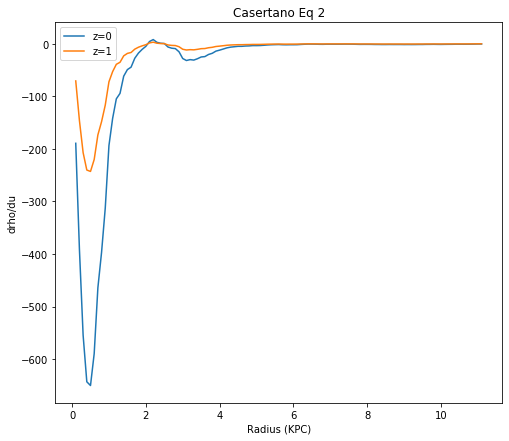

In [13]:
# Plot 
plt.figure(figsize=(8,7))
plt.plot(radii,drho_du(radii,0,z0,mode), label="z=0")
plt.plot(radii,drho_du(radii,1,z0,mode), label="z=1")
plt.title("Casertano Eq 2")
plt.xlabel("Radius (KPC)")
plt.ylabel("drho/du")
plt.legend()
plt.show()

In [14]:
# Casertano Eq 5
def px(r,u,z):
    x = (r**2 + u**2 + z**2)/(2*r*u)
    return x - (np.sqrt((x**2)-1))

print(px(1,1,1))

0.3819660112501051


In [15]:
# Rotmod elliptic integral and p function (Casertano: Eq A.16)
def func(x,y,z):
    if( x == y ) & ( z == 0):
        r = 0
    elif( x == 0 ) | ( y == 0):
        r = 0
    else:
        xxx = (x*x + y*y + z*z) / (2.0 * x * y)
        rrr = (xxx*xxx - 1.0)
        ppp = 1.0 / (xxx + np.sqrt(rrr))
        fm = 1.0 - ppp*ppp
        el1 = (1.3862944 + fm * (0.1119723 + fm * 0.0725296)) - (0.5 + fm * (0.1213478 + fm * 0.0288729)) * np.log(fm)
        el2 = (1.0 + fm * ( 0.4630151 + fm * 0.1077812 ) ) - (fm * (0.2452727 + fm * 0.0412496)) * np.log(fm)
        r = ((1.0 - xxx * y/x) * el2 / (rrr) + (y/x - ppp) * el1 / np.sqrt(rrr)) / np.pi
        r *= np.sqrt(x / (y * ppp))
    return r

In [16]:
# Complete elliptic integral
def K(r,u,z):
    return ellipk(px(r,u,z)) - ellipe(px(r,u,z))

print(K(1,1,1))

0.35734399698214614


In [17]:
# Integrand, using built-in functions
def integrand(z,r,u,z0,G,mode):
    return ((4 * np.pi * G) * drho_du(u,z,z0,mode) * K(r,u,z) * 2 * np.sqrt(u)) / (np.pi * np.sqrt(r * px(r,u,z)))
    
print(integrand(3,2,1,z0,G,mode))

-9.460077370361775e-06


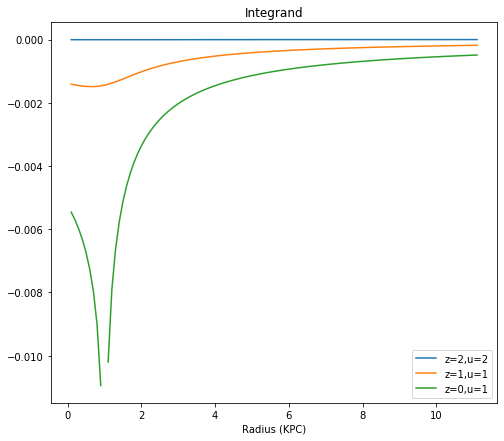

In [18]:
# Plot 
plt.figure(figsize=(8,7))
plt.plot(radii,integrand(2,radii,2,z0,G,mode), label="z=2,u=2")
plt.plot(radii,integrand(1,radii,1,z0,G,mode), label="z=1,u=1")
plt.plot(radii,integrand(0,radii,1,z0,G,mode), label="z=0,u=1")
plt.title("Integrand")
plt.xlabel("Radius (KPC)")
plt.legend()
plt.show()

## Integration

In [19]:
# Define minimum and maximum values of radius for integration
intmin = np.min(radii)
#intmax = np.max(radii)
intmax = np.inf

### Integration, using built-in python functions: scipy quad

In [20]:
# Reverse order of variables to setup for integration
#integrand2 = lambda z,u,r,z0,G,mode: integrand(r,u,z,z0,G,mode)

# Inner integral, integral over z
integrand2 = lambda u,r,z0,G,mode: quad(integrand, intmin, intmax, args=(r,u,z0,G,mode))[0]
print(integrand2(2,1,z0,G,mode))

# Outer integral, integral over u
radialforce = lambda r,z0,G,mode: quad(integrand2, intmin,intmax, args=(r,z0,G,mode))[0]

# Calculate radial force
radialforce = np.vectorize(radialforce)
print(radialforce(1,z0,G,mode))

C:\Users\JB\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in double_scalars
  del sys.path[0]
C:\Users\JB\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in cosh
  # This is added back by InteractiveShellApp.init_path()


-0.00012659177691304923


C:\Users\JB\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\integrate\quadpack.py:385: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)
C:\Users\JB\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\integrate\quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)
C:\Users\JB\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarni

-4.894152234814269e+16


C:\Users\JB\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\function_base.py:2167: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)


### Integration, using ROTMOD functions

### Integration, using built-in python functions: scipy simps

### Integration, using manual simpson's rule

In [21]:
"""def simpson(f,a,b,n):
    h = (b - a) / (n - 1)
    x = np.linspace(a, b, n)
    print(type(f))
    simpson = (h/3) * (f[0] + 2*sum(f[:n-2:2]) + 4*sum(f[1:n-1:2]) + f[n-1])
    return simpson"""

def simpson(f, a, b, n, args):
    h=(b-a)/n
    k=0.0
    x=a
    nhalf = int(n/2) #Workaround for type handling issue
    for i in range(1,nhalf):
        x += 2*h
        k += 4*f(x,*args)
    for i in range(2,nhalf-1):
        x += 2*h
        k += 2*f(x,*args)
    return (h/3)*(f(a,*args)+f(b,*args)+k)

z = np.array([0.02, 0.50, 1.00, 3.00, 10.00])
u = np.array([0.02, 0.50, 1.00, 3.00, 10.00])

# Reverse order of variables to setup for integration
# Changed the name of this because it interfered with radialforce function
integrand3 = lambda z,u,r,z0,G,mode: integrand(z,r,u,z0,G,mode)

# Inner integral, integral over z
integrand3_simps2 = lambda u,r,z0,G,mode: simpson(integrand3, 0, np.inf, 100,args=(u,r,z0,G,mode))
print(integrand3_simps2)
print(integrand3_simps2(2,1,z0,G,mode))

# Outer integral, integral over u
radialforce_simps2 = lambda r,z0,G,mode: simpson(integrand3_simps2, 1e-20, np.inf, 100,args=(r,z0,G,mode))

# Calculate radial force
radialforce_simps2 = np.vectorize(radialforce_simps2)
print(radialforce_simps2(1,z0,G,mode))

# Velocity
velocs_simps2 = np.sqrt(-radii*radialforce_simps2(radii,z0,G,mode))

C:\Users\JB\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.
C:\Users\JB\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


<function <lambda> at 0x0000020D05433BF8>
nan
nan


In [22]:
a = 0
b = np.pi
n = 11
h = (b - a) / (n - 1)
x = np.linspace(a, b, n)
f = np.sin(x)
print(type(f))
print(f)
I_simp = (h/3) * (f[0] + 2*sum(f[:n-2:2]) \
            + 4*sum(f[1:n-1:2]) + f[n-1])
err_simp = 2 - I_simp

print(I_simp)
print(err_simp)

<class 'numpy.ndarray'>
[0.00000000e+00 3.09016994e-01 5.87785252e-01 8.09016994e-01
 9.51056516e-01 1.00000000e+00 9.51056516e-01 8.09016994e-01
 5.87785252e-01 3.09016994e-01 1.22464680e-16]
2.0001095173150043
-0.00010951731500430384


## Velocity

In [23]:
print(radii)

forces = radialforce(radii,z0,G,mode)
print(forces)

velocs = np.sqrt(-radii*radialforce(radii,z0,G,mode))
print(velocs)

velocs_smooth = savgol_filter(velocs[np.isnan(velocs) == False], 11, 4)

[ 0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.   1.1  1.2  1.3  1.4
  1.5  1.6  1.7  1.8  1.9  2.   2.1  2.2  2.3  2.4  2.5  2.6  2.7  2.8
  2.9  3.   3.1  3.2  3.3  3.4  3.5  3.6  3.7  3.8  3.9  4.   4.1  4.2
  4.3  4.4  4.5  4.6  4.7  4.8  4.9  5.   5.1  5.2  5.3  5.4  5.5  5.6
  5.7  5.8  5.9  6.   6.1  6.2  6.3  6.4  6.5  6.6  6.7  6.8  6.9  7.
  7.1  7.2  7.3  7.4  7.5  7.6  7.7  7.8  7.9  8.   8.1  8.2  8.3  8.4
  8.5  8.6  8.7  8.8  8.9  9.   9.1  9.2  9.3  9.4  9.5  9.6  9.7  9.8
  9.9 10.  10.1 10.2 10.3 10.4 10.5 10.6 10.7 10.8 10.9 11.  11.1]


C:\Users\JB\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in double_scalars
  del sys.path[0]
C:\Users\JB\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in cosh
  # This is added back by InteractiveShellApp.init_path()
C:\Users\JB\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


[-4.89393174e+16 -4.89395608e+16 -4.89398063e+16 -4.89400514e+16
 -4.89402966e+16 -4.89405417e+16 -4.89407869e+16 -4.89410321e+16
 -4.89412772e+16 -4.89415223e+16 -4.89417675e+16 -4.89420127e+16
 -4.89422579e+16 -4.89425030e+16 -4.89427482e+16 -4.89429934e+16
 -4.89432386e+16 -4.89434838e+16 -4.89437290e+16 -4.89439742e+16
 -4.89442194e+16 -4.89444646e+16 -4.89447098e+16 -4.89449550e+16
 -4.89452003e+16 -4.89454455e+16 -4.89456907e+16 -4.89459360e+16
 -4.89461812e+16 -4.89464264e+16 -4.89466717e+16 -4.89469169e+16
 -4.89471622e+16 -4.89474075e+16 -4.89476527e+16 -4.89478980e+16
 -4.89481433e+16 -4.89483885e+16 -4.89486338e+16 -4.89488791e+16
 -4.89491244e+16 -4.89493697e+16 -4.89496150e+16 -4.89498603e+16
 -4.89501056e+16 -4.89503509e+16 -4.89505962e+16 -4.89508415e+16
 -4.89510868e+16 -4.89513322e+16 -4.89515775e+16 -4.89518228e+16
 -4.89520682e+16 -4.89523135e+16 -4.89525589e+16 -4.89528042e+16
 -4.89530496e+16 -4.89532949e+16 -4.89535403e+16 -4.89537856e+16
 -4.89540310e+16 -4.89542

## Comparison

In [24]:
# Gas
tracedgas = np.loadtxt("../NGC_5005/traced_data/ngc5005_gas.txt")
tracedgas_r, tracedgas_v = tracedgas.T
tracedgas_r = tracedgas_r[1:]
tracedgas_v = tracedgas_v[1:]

# Disk
traceddisk = np.loadtxt("../NGC_5005/traced_data/ngc5005_disk.txt")
traceddisk_r, traceddisk_v = traceddisk.T
traceddisk_r = traceddisk_r[1:]
traceddisk_v = traceddisk_v[1:]

## Plot

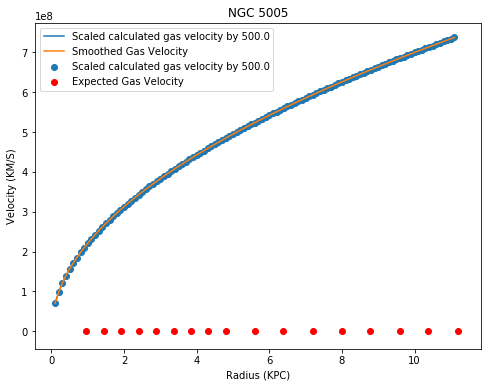

In [25]:
scale = 5e2
plt.figure(figsize=(8,6))             
#plt.scatter(radii, scale*velocs, linestyle='solid', label='Scaled calculated gas velocity by {}'.format(scale))
#plt.plot(radii, scale*velocs, linestyle='solid', label='Scaled calculated gas velocity by {}'.format(scale))
#plt.plot(radii[np.isnan(velocs)==False], scale*velocs_smooth, linestyle='solid', label='Smoothed Gas Velocity')
plt.scatter(radii, velocs, linestyle='solid', label='Scaled calculated gas velocity by {}'.format(scale))
plt.plot(radii, velocs, linestyle='solid', label='Scaled calculated gas velocity by {}'.format(scale))
plt.plot(radii[np.isnan(velocs)==False], velocs_smooth, linestyle='solid', label='Smoothed Gas Velocity')
#plt.plot(radii, scale*velocs_rotmod, linestyle='solid', label='Rotmod functions')
#plt.plot(radii, scale*velocs_simps, linestyle='solid', label='Scipy Simpson rule')
plt.scatter(tracedgas_r, tracedgas_v, label='Expected Gas Velocity', c='red')
plt.axis('tight');
plt.title('NGC 5005')
plt.xlabel('Radius (KPC)', fontsize=10)
plt.ylabel('Velocity (KM/S)', fontsize=10)
#plt.xlim(0,12)
plt.legend(fontsize=10)
plt.show()

In [26]:
print(radii)
print(velocs)

[ 0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.   1.1  1.2  1.3  1.4
  1.5  1.6  1.7  1.8  1.9  2.   2.1  2.2  2.3  2.4  2.5  2.6  2.7  2.8
  2.9  3.   3.1  3.2  3.3  3.4  3.5  3.6  3.7  3.8  3.9  4.   4.1  4.2
  4.3  4.4  4.5  4.6  4.7  4.8  4.9  5.   5.1  5.2  5.3  5.4  5.5  5.6
  5.7  5.8  5.9  6.   6.1  6.2  6.3  6.4  6.5  6.6  6.7  6.8  6.9  7.
  7.1  7.2  7.3  7.4  7.5  7.6  7.7  7.8  7.9  8.   8.1  8.2  8.3  8.4
  8.5  8.6  8.7  8.8  8.9  9.   9.1  9.2  9.3  9.4  9.5  9.6  9.7  9.8
  9.9 10.  10.1 10.2 10.3 10.4 10.5 10.6 10.7 10.8 10.9 11.  11.1]
[6.99566418e+07 9.89338777e+07 1.21169063e+08 1.39914333e+08
 1.56429372e+08 1.71360220e+08 1.85090656e+08 1.97870730e+08
 2.09874128e+08 2.21227309e+08 2.32025741e+08 2.42343589e+08
 2.52239837e+08 2.61762305e+08 2.70950406e+08 2.79837077e+08
 2.88450179e+08 2.96813529e+08 3.04947676e+08 3.12870498e+08
 3.20597662e+08 3.28142990e+08 3.35518751e+08 3.42735893e+08
 3.49804232e+08 3.56732615e+08 3.63529043e+08 3.70200784e+08
 3.7675446